✅ 로드 완료: train=392  valid=44
Fused dims → train:(392, 1024), valid:(44, 1024)
🔧 모델 파라미터 수: 1,312,514
[01/60]  loss=0.6901  train_acc=51.53%  valid_acc=63.64%
[02/60]  loss=0.6600  train_acc=64.29%  valid_acc=63.64%
[03/60]  loss=0.6499  train_acc=63.78%  valid_acc=77.27%
[04/60]  loss=0.6284  train_acc=71.17%  valid_acc=77.27%
[05/60]  loss=0.6018  train_acc=71.68%  valid_acc=77.27%
[06/60]  loss=0.5669  train_acc=77.81%  valid_acc=79.55%
[07/60]  loss=0.5420  train_acc=76.79%  valid_acc=79.55%
[08/60]  loss=0.5122  train_acc=79.34%  valid_acc=79.55%
[09/60]  loss=0.4870  train_acc=80.10%  valid_acc=81.82%
[10/60]  loss=0.4600  train_acc=83.67%  valid_acc=86.36%
[11/60]  loss=0.4361  train_acc=84.18%  valid_acc=86.36%
[12/60]  loss=0.3816  train_acc=85.71%  valid_acc=86.36%
[13/60]  loss=0.3681  train_acc=88.27%  valid_acc=86.36%
[14/60]  loss=0.3451  train_acc=88.27%  valid_acc=86.36%
[15/60]  loss=0.3408  train_acc=86.73%  valid_acc=81.82%
[16/60]  loss=0.3080  train_acc=88.27%  vali

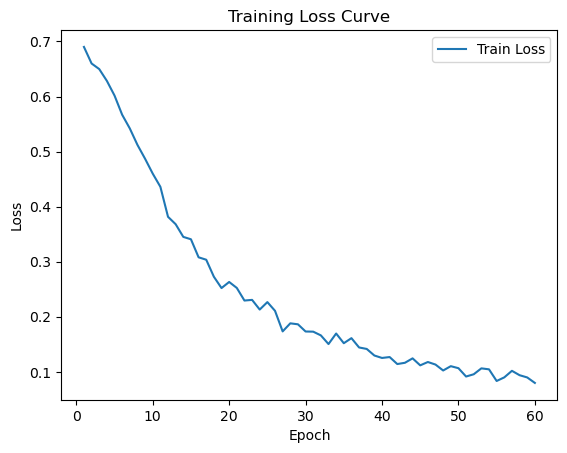

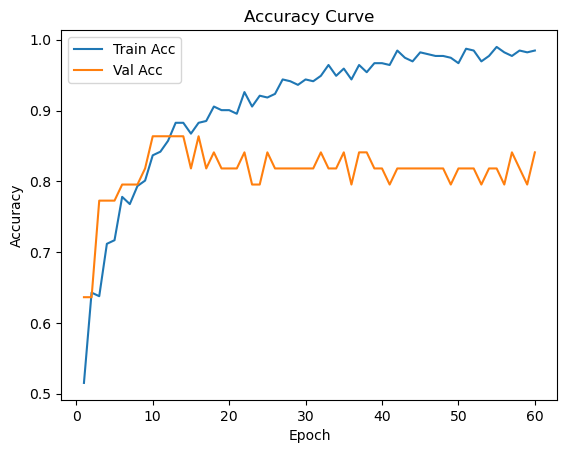

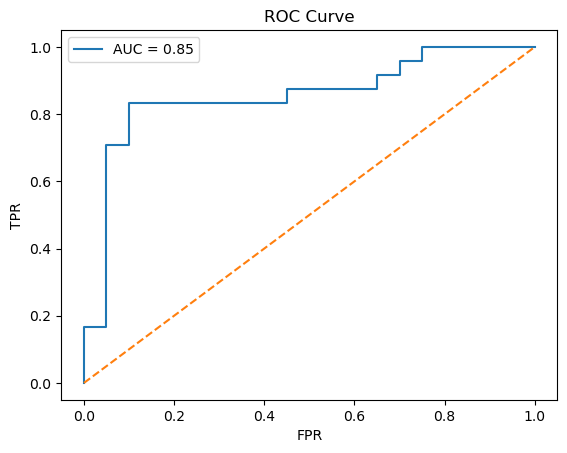

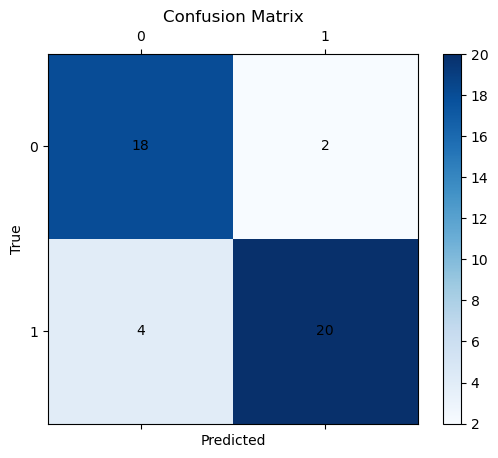

In [10]:
# =========================================================
#               설정(필요 시만 수정)
# =========================================================
from pathlib import Path
import json, time, numpy as np, torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# ----------------- 하이퍼파라미터 ----------------------
DATA_ROOT = Path(r"embbeding_data")   # 임베딩 데이터 폴더
AGG_METHOD = "mean"                   # "mean" | "max" | "flatten"
BATCH      = 64                        # 배치 크기
EPOCHS     = 60                        # 에폭 수
LR         = 1e-4                      # 학습률
WEIGHT_DECAY = 1e-4                    # AdamW 가중치 감쇠
HIDDEN_DIMS = (1024, 256)              # 은닉층 크기
DROPOUT_P  = 0.5                       # 드롭아웃 비율
DEVICE     = "cuda:0" if torch.cuda.is_available() else "cpu"
SAVE_DIR   = Path(r"D:\golf\fusion_ckpt")  # 저장 디렉토리

# ---------- 데이터 로드 --------------------------------------------------
def load_split(split: str, model: str):
    base = DATA_ROOT / model / split
    emb  = np.load(base / "embeddings.npy")
    lbl  = np.load(base / "labels.npy").ravel()
    return emb, lbl

# Timesformer & ST-GCN 임베딩 로드
ts_tr, y_tr = load_split("train", "timesformer")
ts_va, y_va = load_split("valid", "timesformer")
st_tr, _    = load_split("train", "stgcnpp")
st_va, _    = load_split("valid", "stgcnpp")

# 레이블 확인
assert (y_tr == np.load(DATA_ROOT/"stgcnpp/train/labels.npy").ravel()).all()
assert (y_va == np.load(DATA_ROOT/"stgcnpp/valid/labels.npy").ravel()).all()
print(f"✅ 로드 완료: train={ts_tr.shape[0]}  valid={ts_va.shape[0]}")

# ---------- ST-GCN 임베딩 축소 -------------------------------------------
def reduce_stgcn(arr):
    if AGG_METHOD == "mean":
        return np.nanmean(arr, axis=1)
    if AGG_METHOD == "max":
        return np.nanmax(arr, axis=1)
    if AGG_METHOD == "flatten":
        return arr.reshape(arr.shape[0], -1)
    raise ValueError(f"AGG_METHOD={AGG_METHOD}")

st_tr_flat = reduce_stgcn(st_tr)
st_va_flat = reduce_stgcn(st_va)

# ---------- 특징 결합 ----------------------------------------------------
X_tr = np.concatenate([ts_tr, st_tr_flat], axis=1).astype(np.float32)
X_va = np.concatenate([ts_va, st_va_flat], axis=1).astype(np.float32)
y_tr = y_tr.astype(np.int64)
y_va = y_va.astype(np.int64)

print(f"Fused dims → train:{X_tr.shape}, valid:{X_va.shape}")

# ---------- DataLoader --------------------------------------------------
ds_tr = TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr))
ds_va = TensorDataset(torch.from_numpy(X_va), torch.from_numpy(y_va))
dl_tr = DataLoader(ds_tr, batch_size=BATCH, shuffle=True)
dl_va = DataLoader(ds_va, batch_size=BATCH, shuffle=False)

# ---------- 모델 정의 ----------------------------------------------------
class FusionMLP(nn.Module):
    def __init__(self, in_dim, n_cls, hidden, p_drop):
        super().__init__()
        layers, dims = [], [in_dim, *hidden]
        for d_in, d_out in zip(dims[:-1], dims[1:]):
            layers += [nn.Linear(d_in, d_out), nn.ReLU(), nn.Dropout(p_drop)]
        layers += [nn.Linear(dims[-1], n_cls)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# 클래스 수
n_cls = int(max(y_tr.max(), y_va.max())) + 1
model = FusionMLP(in_dim=X_tr.shape[1], n_cls=n_cls,
                  hidden=HIDDEN_DIMS, p_drop=DROPOUT_P).to(DEVICE)
opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.5)
crit  = nn.CrossEntropyLoss()

print(f"🔧 모델 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")

# ---------- 학습 및 평가 ----------------------------------------------
train_losses, train_accs, val_accs = [], [], []
val_probs = []

best_acc, best_state = 0.0, None
for epoch in range(1, EPOCHS+1):
    # --- train ---
    model.train()
    loss_sum, n_correct, n_total = 0.0, 0, 0
    for x, y in dl_tr:
        x, y = x.to(DEVICE), y.to(DEVICE)
        opt.zero_grad()
        out = model(x)
        loss = crit(out, y)
        loss.backward()
        opt.step()

        loss_sum  += loss.item() * y.size(0)
        n_correct += (out.argmax(1) == y).sum().item()
        n_total   += y.size(0)
    scheduler.step()
    tr_loss = loss_sum / n_total
    tr_acc  = n_correct / n_total
    train_losses.append(tr_loss)
    train_accs.append(tr_acc)

    # --- valid ---
    model.eval()
    y_true, y_pred = [], []
    probs_epoch = []
    with torch.no_grad():
        for x, y in dl_va:
            x = x.to(DEVICE)
            out = model(x)
            prob = torch.softmax(out, dim=1)[:,1].cpu().numpy()
            probs_epoch.extend(prob)
            y_true.append(y)
            y_pred.append(out.argmax(1).cpu())
    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()
    val_acc = accuracy_score(y_true, y_pred)
    val_accs.append(val_acc)
    val_probs.append(probs_epoch)

    print(f"[{epoch:02d}/{EPOCHS}]  loss={tr_loss:.4f}  train_acc={tr_acc*100:.2f}%  valid_acc={val_acc*100:.2f}%")

    if val_acc > best_acc:
        best_acc, best_state = val_acc, model.state_dict()
        best_true, best_pred = y_true, y_pred
        best_probs = probs_epoch.copy()

# ---------- 저장 및 리포트 ----------------------------------------------
if SAVE_DIR:
    SAVE_DIR.mkdir(parents=True, exist_ok=True)
    torch.save(best_state, SAVE_DIR / "fusion_mlp_best.pth")
    with open(SAVE_DIR / "meta.json", "w", encoding="utf-8") as f:
        json.dump({
            "input_dim": X_tr.shape[1],
            "n_classes": n_cls,
            "valid_acc": best_acc,
            "agg_method": AGG_METHOD,
            "hidden": list(HIDDEN_DIMS),
            "epochs": EPOCHS,
            "lr": LR,
            "batch": BATCH
        }, f, indent=2)
    print(f"\n✅ 가중치 저장 → {SAVE_DIR/'fusion_mlp_best.pth'}")

# ---------- 최종 리포트 --------------------------------------------------
print("\n" + classification_report(best_true, best_pred, digits=4))
print(f"🏅 Best VALID ACC = {best_acc*100:.2f}%")

# ---------- 학습 곡선 시각화 ----------------------------------------------
epochs = list(range(1, EPOCHS+1))

plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.title('Training Loss Curve'), plt.legend()
plt.savefig(SAVE_DIR / 'loss_curve.png')

plt.figure()
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs, label='Val Acc')
plt.xlabel('Epoch'), plt.ylabel('Accuracy')
plt.title('Accuracy Curve'), plt.legend()
plt.savefig(SAVE_DIR / 'accuracy_curve.png')

# ---------- ROC 곡선 시각화 ----------------------------------------------
y_true_all = np.array(best_true)
y_scores_all = np.array(best_probs)
fpr, tpr, _ = roc_curve(y_true_all, y_scores_all)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], '--')
plt.xlabel('FPR'), plt.ylabel('TPR')
plt.title('ROC Curve'), plt.legend()
plt.savefig(SAVE_DIR / 'roc_curve.png')

# ---------- 혼동 행렬 시각화 ----------------------------------------------
cm = confusion_matrix(best_true, best_pred)
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap='Blues')
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, str(z), ha='center', va='center')
fig.colorbar(cax)
ax.set_xlabel('Predicted'), ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
fig.savefig(SAVE_DIR / 'confusion_matrix.png')


In [4]:
import numpy as np, pandas as pd
root = Path(r"embbeding_data")
y_ts = np.load(root/'timesformer/train/labels.npy').ravel().astype(int)
y_st = np.load(root/'stgcnpp/train/labels.npy').ravel().astype(int)

mismatch_idx = np.where(y_ts != y_st)[0]
print(f"⚠️  서로 다른 위치: {mismatch_idx[:10]} ... 총 {len(mismatch_idx)}개")
pd.DataFrame({'idx': mismatch_idx,
              'ts_label': y_ts[mismatch_idx],
              'st_label': y_st[mismatch_idx]})


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\qqppq\anaconda3\envs\fusion\lib\site-packages\IPython\core\interactiveshell.py", line 3579, in run_code
  File "C:\Users\qqppq\AppData\Local\Temp\ipykernel_1972\1198015937.py", line 1, in <module>
    import numpy as np, pandas as pd
ModuleNotFoundError: No module named 'numpy'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\qqppq\anaconda3\envs\fusion\lib\site-packages\pygments\styles\__init__.py", line 45, in get_style_by_name
ModuleNotFoundError: No module named 'pygments.styles.default'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\qqppq\anaconda3\envs\fusion\lib\site-packages\IPython\core\interactiveshell.py", line 2170, in showtraceback
  File "c:\Users\qqppq\anaconda3\envs\fusion\lib\site-packages\IPython\core\ultratb.py", line 1457, in structured_traceback
  File "c:\Users\qqppq\